In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')

In [55]:
import pandas as pd 

REGION = 'AEP'
df = pd.read_csv(f"../data/raw/{REGION}_hourly.csv") #American Electric Power (AEP) estimated energy consumption in Megawatts (MW)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values(by='Datetime').reset_index(drop=True)
df = df.set_index('Datetime')
df['load_mw'] = df[f'{region}_MW']


<Axes: xlabel='Datetime'>

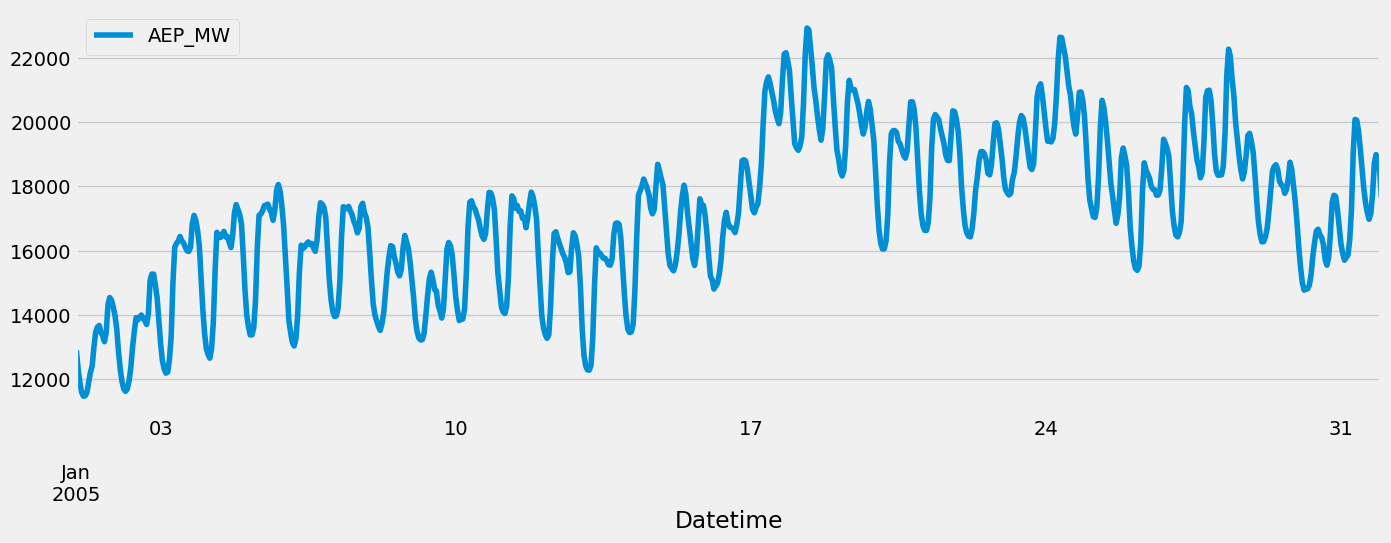

In [64]:
df = df.loc['2005-01']
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
train = df.iloc[:480]
test = df.iloc[480:]

In [71]:

import matplotlib.pyplot as plt


def plot(df_plot,title = ''):

    plt.figure(figsize=(12, 5))

    # Actual
    plt.plot(df_plot.index, df_plot['load_mw'], label='Actual', color='black')

    # Predictions
    plt.plot(train_pred.index, train_pred['yhat'], label='Train Forecast', color='blue')
    plt.plot(test_pred.index, test_pred['yhat'], label='Test Forecast', color='red')

    # Vertical line at start of test
    plt.axvline(test.index[0], color='green', linestyle='--', label='Test Start')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.legend()
    plt.grid(True)
    plt.show()

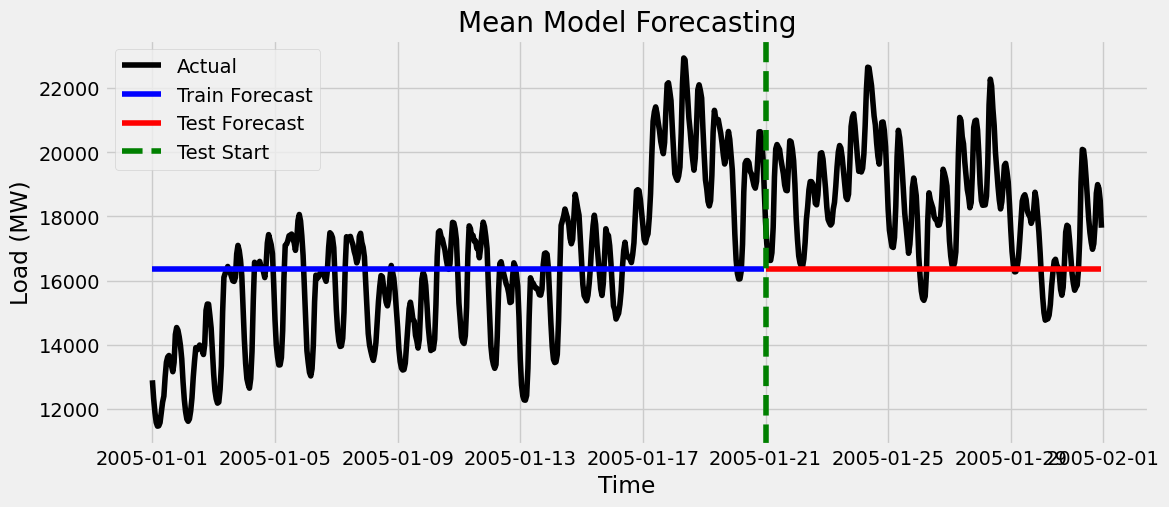

In [73]:

class MeanModel:

    def __init__(self):
        self.predict = None
    def fit(self,train):
        self.predict = train['load_mw'].mean()
        train = train.copy()
        train['yhat'] = self.predict

        return train
    
    def eval(self,test):
        test = test.copy()
        test['yhat'] = self.predict
        return test
        
mean_model = MeanModel()
train_pred = mean_model.fit(train)
test_pred= mean_model.eval(test)

df_plot = pd.concat([train_pred, test_pred])
plot(df_plot, title='Mean Model Forecasting')


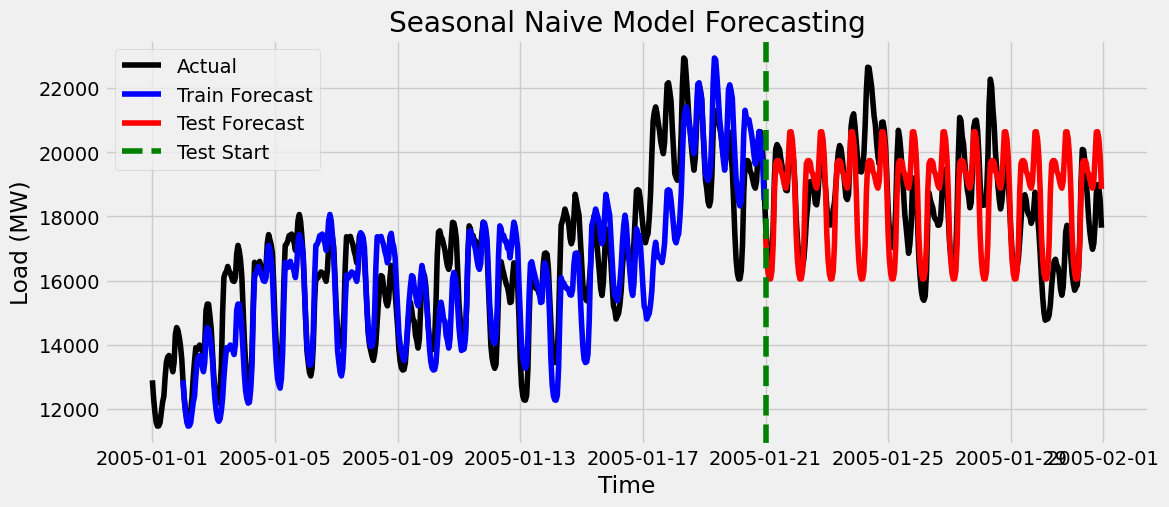

In [74]:
import numpy as np
class SeasonalNaiveModel:

    def __init__(self, lag=24):
        self.lag = lag
        self.last_values = None  
        
    def fit(self, train):
        train = train.copy()
        

        self.last_values = train['load_mw'].iloc[-self.lag:]
        
        
        train['yhat'] = train['load_mw'].shift(self.lag)
        
        return train
    
    def eval(self, test):
        test = test.copy()
        
        # Repeat last seasonal cycle to cover test length
        repeats = int(np.ceil(len(test) / self.lag))
        forecast_values = np.tile(self.last_values.values, repeats)[:len(test)]
        
        test['yhat'] = forecast_values
        
        return test


sn_model = SeasonalNaiveModel(lag=24)

train_pred = sn_model.fit(train)
test_pred = sn_model.eval(test)

df_plot = pd.concat([train_pred, test_pred])
plot(df_plot, title='Seasonal Naive Model Forecasting')


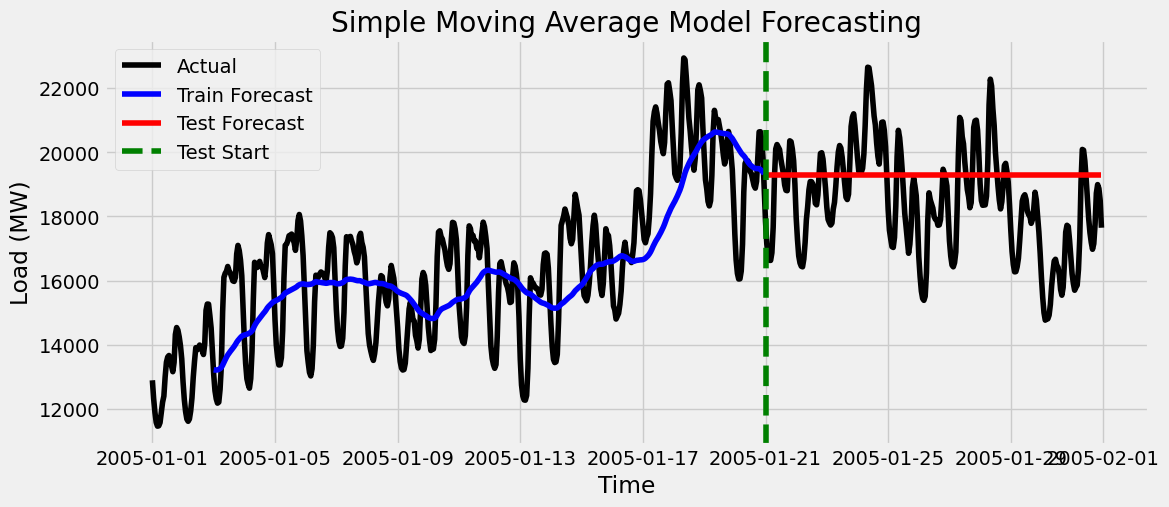

In [78]:
import numpy as np
import pandas as pd

class SimpleMovingAverageModel:

    def __init__(self, k=48):
        self.k = k
        self.last_k_values = None   # store last k actual values
    
    def fit(self, train):
        train = train.copy()
        
        # store last k actual values for forecasting
        self.last_k_values = train['load_mw'].iloc[-self.k:]
        
        # compute moving average
        rolling_mean = train['load_mw'].rolling(self.k + 1).mean()
        train['yhat'] = rolling_mean
        
        return train
    
    def eval(self, test):
        test = test.copy()
        
        # out-of-sample: forecast = mean of last k values
        mean_value = self.last_k_values.mean()
        
        test['yhat'] = mean_value
        
        return test


sma = SimpleMovingAverageModel(k=48)

train_pred = sma.fit(train)
test_pred = sma.eval(test)

df_plot = pd.concat([train_pred, test_pred])
plot(df_plot, title='Simple Moving Average Model Forecasting')


/home/erfan/anaconda3/envs/classical/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/erfan/anaconda3/envs/classical/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


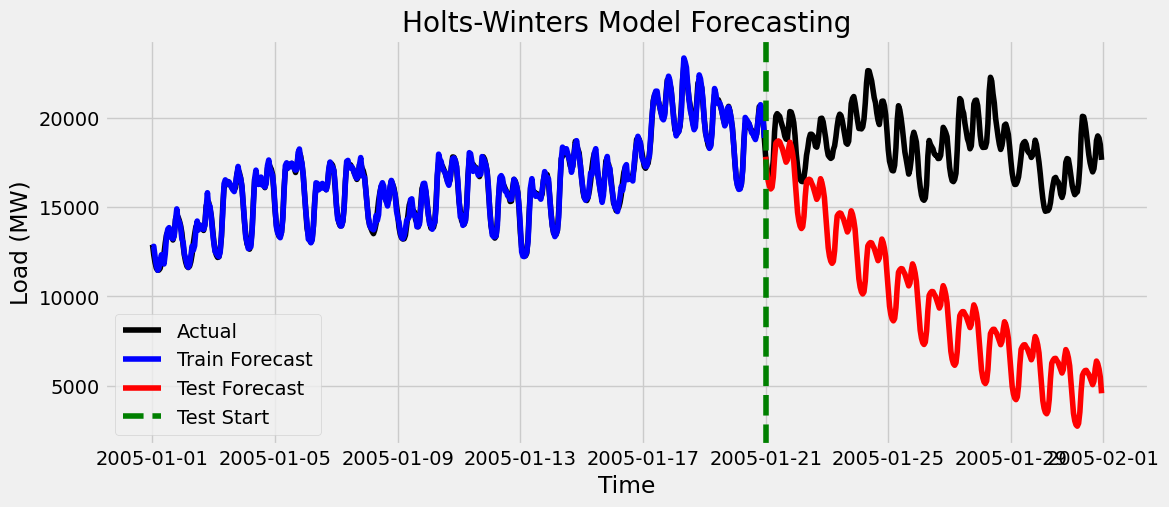

In [84]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

class HoltWintersModel:

    def __init__(self, season_length=24, trend='add', seasonal='add'):
        """
        season_length: seasonal period (e.g., 24 for hourly daily seasonality)
        trend: 'add', 'mul', or None
        seasonal: 'add', 'mul', or None
        """
        self.season_length = season_length
        self.trend = trend
        self.seasonal = seasonal
        self.model = None
        self.fitted = None

    def fit(self, train):
        train = train.copy()

        # Fit the Holt-Winters/ETS model
        self.model = ExponentialSmoothing(
            train['load_mw'],
            trend=self.trend,
            seasonal=self.seasonal,
            seasonal_periods=self.season_length,
            initialization_method="estimated"
        )

        self.fitted = self.model.fit()

        # In-sample predictions
        train['yhat'] = self.fitted.fittedvalues

        return train
    
    def eval(self, test):
        test = test.copy()

        # Forecast next len(test) steps
        forecast = self.fitted.forecast(len(test))
        test['yhat'] = forecast.values

        return test

hw = HoltWintersModel(season_length=24, trend='mul', seasonal='add')

train_pred = hw.fit(train)
test_pred  = hw.eval(test)

df_plot = pd.concat([train_pred, test_pred])
plot(df_plot, title='Holts-Winters Model Forecasting')


[  -51.52436732    70.32376199 -1052.8730256   -757.18118651
   -61.375814      18.52595927 -1125.7196342     26.59840871]
Index(['sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3', 'sin_4', 'cos_4'], dtype='object')


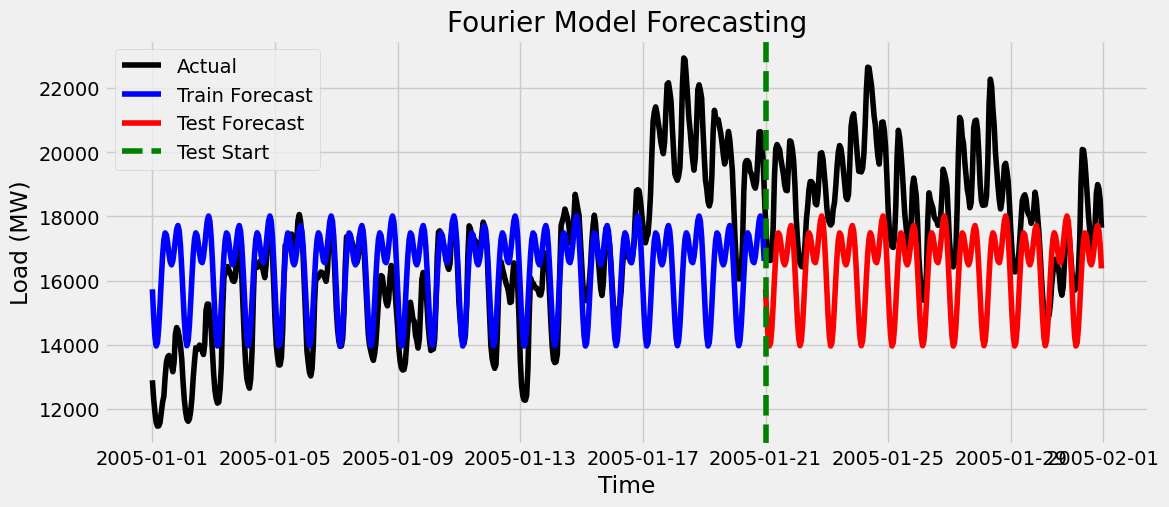

In [93]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

class FourierLinearRegression:
    
    def __init__(self, period=24, K=5):
        """
        period: length of the seasonal cycle (e.g., 24 hours)
        K: number of Fourier pairs (sin_k, cos_k)
        """
        self.period = period
        self.K = K
        self.model = None
        self.feature_cols = None
        self.last_t = None    # to continue Fourier index in test
    
    def _make_fourier(self, t):
        """Return a DataFrame of Fourier features for a given t index."""
        data = {}
        
        for k in range(1, self.K + 1):
            data[f'sin_{k}'] = np.sin(2 * np.pi * k * t / self.period)
            data[f'cos_{k}'] = np.cos(2 * np.pi * k * t / self.period)
        
        return pd.DataFrame(data, index=t.index)
    
    def fit(self, train):
        train = train.copy()
        
        # time index t = 0, 1, ..., n-1
        t = pd.Series(np.arange(len(train)), index=train.index)
        self.last_t = t.iloc[-1]
        
        # build Fourier features
        X = self._make_fourier(t)
        self.feature_cols = X.columns
        
        # fit LR model
        self.model = LinearRegression()
        self.model.fit(X, train["load_mw"])
        self.importance = self.model.coef_
        # in-sample prediction
        train["yhat"] = self.model.predict(X)
        
        return train
    
    def eval(self, test):
        test = test.copy()
        
        # extend t into the future
        t_future = pd.Series(
            np.arange(self.last_t + 1, self.last_t + 1 + len(test)),
            index=test.index
        )
        
        # build Fourier features for future t
        X_future = self._make_fourier(t_future)
        
        # predictions
        test["yhat"] = self.model.predict(X_future)
        
        return test

# daily seasonality for hourly data
flr = FourierLinearRegression(period=48, K=4)

train_pred = flr.fit(train)
print(flr.importance)
print(flr.feature_cols)
test_pred  = flr.eval(test)

df_plot = pd.concat([train_pred, test_pred])
plot(df_plot, title='Fourier Model Forecasting')


/home/erfan/anaconda3/envs/classical/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/erfan/anaconda3/envs/classical/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/erfan/anaconda3/envs/classical/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


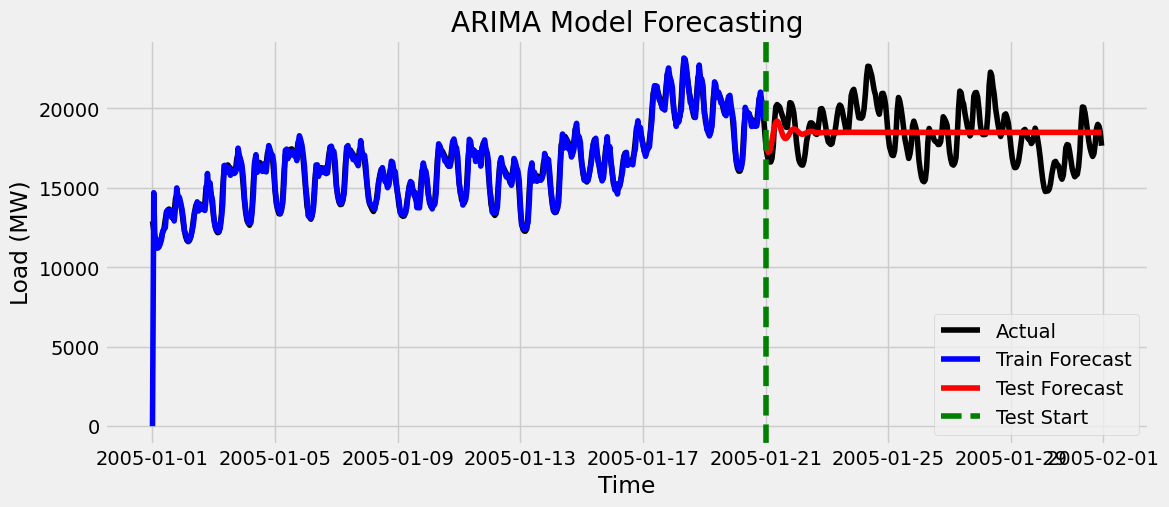

In [99]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

class ARIMAModel:

    def __init__(self, order=(3,1,1)):
        """
        order = (p, d, q)
        p: autoregressive order
        d: differencing order
        q: moving-average order
        """
        self.order = order
        self.model = None
        self.fitted = None
        
    def fit(self, train):
        train = train.copy()
        
        # fit ARIMA
        self.model = ARIMA(train['load_mw'], order=self.order)
        self.fitted = self.model.fit()
        
        # in-sample predictions
        train['yhat'] = self.fitted.predict(start=train.index[0], end=train.index[-1])
        
        return train
    
    def eval(self, test):
        test = test.copy()
        
        # forecast next len(test) steps
        forecast = self.fitted.forecast(len(test))
        test['yhat'] = forecast.values
        
        return test

arima = ARIMAModel(order=(6,1,1))

train_pred = arima.fit(train)
test_pred  = arima.eval(test)

df_plot = pd.concat([train_pred, test_pred])
plot(df_plot, title='ARIMA Model Forecasting')


18:27:17 - cmdstanpy - INFO - Chain [1] start processing


18:27:18 - cmdstanpy - INFO - Chain [1] done processing


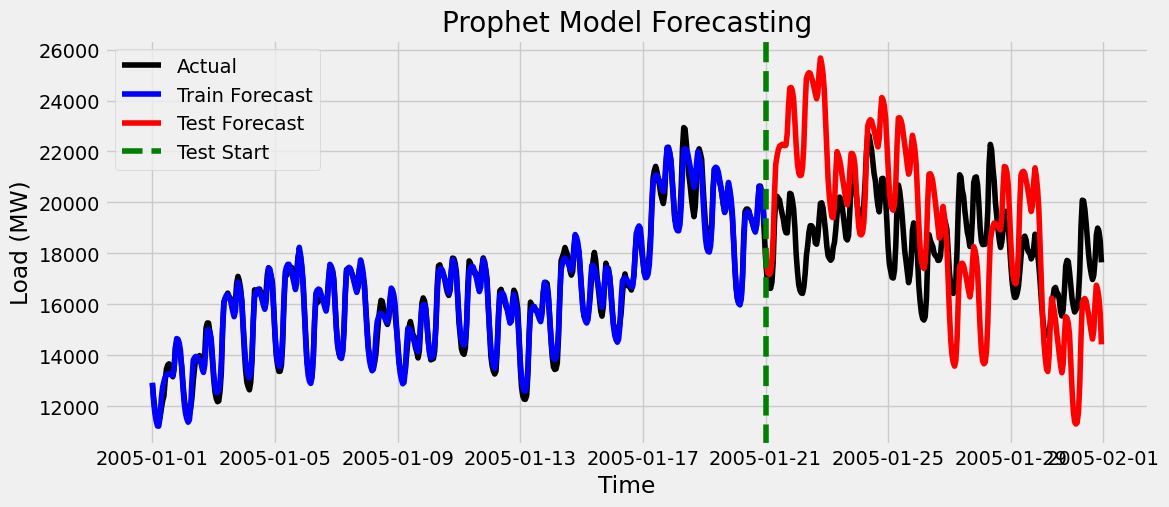

In [116]:
from prophet import Prophet
import pandas as pd

class ProphetModel:

    def __init__(
        self,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode="additive",
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0,
        holidays_prior_scale=10.0,
        n_changepoints=40,
        interval_width=0.95,

        # Optional custom Fourier orders
        yearly_fourier_order=None,
        weekly_fourier_order=None,
        daily_fourier_order=None,

        # Optional regressors (list of column names)
        extra_regressors=None,
    ):
        self.extra_regressors = extra_regressors or []

        self.model = Prophet(
            yearly_seasonality=yearly_seasonality,
            weekly_seasonality=weekly_seasonality,
            daily_seasonality=daily_seasonality,
            seasonality_mode=seasonality_mode,
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            n_changepoints=n_changepoints,
            interval_width=interval_width
        )

        # Custom Fourier orders
        if yearly_fourier_order is not None:
            self.model.add_seasonality("yearly_custom", period=365.25, fourier_order=yearly_fourier_order)
        if weekly_fourier_order is not None:
            self.model.add_seasonality("weekly_custom", period=7, fourier_order=weekly_fourier_order)
        if daily_fourier_order is not None:
            self.model.add_seasonality("daily_custom", period=1, fourier_order=daily_fourier_order)

        # Extra regressors
        for reg in self.extra_regressors:
            self.model.add_regressor(reg)

        self.fitted = None

    def fit(self, train):
        train = train.copy()

        # Ensure index is DatetimeIndex
        if not isinstance(train.index, pd.DatetimeIndex):
            raise ValueError("Train index must be a DatetimeIndex.")

        # Build Prophet dataframe
        df = pd.DataFrame({
            "ds": train.index,
            "y": train["load_mw"].values
        })

        # Add regressors
        for reg in self.extra_regressors:
            df[reg] = train[reg].values

        # Fit Prophet
        self.fitted = self.model.fit(df)

        # In-sample predictions
        future = df[["ds"] + self.extra_regressors]
        forecast = self.fitted.predict(future)

        train["yhat"] = forecast["yhat"].values
        return train

    def eval(self, test):
        test = test.copy()

        df_test = pd.DataFrame({"ds": test.index})

        # Regressors for test
        for reg in self.extra_regressors:
            df_test[reg] = test[reg].values

        forecast = self.fitted.predict(df_test)
        test["yhat"] = forecast["yhat"].values
        return test


pm = ProphetModel(
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.08,
    seasonality_prior_scale=1,
    n_changepoints=50,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    yearly_fourier_order=10,
    weekly_fourier_order=6,
    daily_fourier_order=10
)

train_pred = pm.fit(train)
test_pred  = pm.eval(test)

df_plot = pd.concat([train_pred, test_pred])
plot(df_plot, title='Prophet Model Forecasting')
